# Autoregressive HMMs

![](https://ars.els-cdn.com/content/image/1-s2.0-S0896627315010375-gr1.jpg)

In this lab we'll develop hidden Markov models, specifically Gaussian and autoregressive hidden Markov models, to analyze depth videos of freely behaving mice. We'll implement, from scratch, the model developed by Wiltschko et al (2015) and extended in Markowitz et al (2018). Figure 1 of Wiltschko et al is reproduced above.




**References**

Markowitz, J. E., Gillis, W. F., Beron, C. C., Neufeld, S. Q., Robertson, K., Bhagat, N. D., ... & Sabatini, B. L. (2018). The striatum organizes 3D behavior via moment-to-moment action selection. Cell, 174(1), 44-58.

Wiltschko, A. B., Johnson, M. J., Iurilli, G., Peterson, R. E., Katon, J. M., Pashkovski, S. L., ... & Datta, S. R. (2015). Mapping sub-second structure in mouse behavior. Neuron, 88(6), 1121-1135.




## Environment Setup

In [1]:
%%capture
!pip install pynwb
!pip install dynamax

In [2]:
# First, import necessary libraries.
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns
from tqdm.auto import trange
from pynwb import NWBHDF5IO
from google.colab import files

import torch
from torch.distributions import MultivariateNormal, Normal

# Specify that we want our tensors on the GPU and in float32
device = torch.device('cpu')
dtype = torch.float32

# Helper function to convert between numpy arrays and tensors
to_t = lambda array: torch.tensor(array, device=device, dtype=dtype)
from_t = lambda tensor: tensor.to("cpu").detach().numpy().astype(np.float64)

In [26]:
#@title Helper functions
import cv2
from matplotlib import animation
from IPython.display import HTML
from tempfile import NamedTemporaryFile
import base64

sns.set_context("notebook")

# initialize a color palette for plotting
palette = sns.xkcd_palette(["windows blue",
                            "red",
                            "medium green",
                            "dusty purple",
                            "greyish",
                            "orange",
                            "amber",
                            "clay",
                            "pink"])


def combine(Ta, a, Tb, b):
    assert a or b
    if a is None:
        return Tb, b
    elif b is None:
        return Ta, a
    else:
        return tuple((Ta * ai + Tb * bi) / (Ta + Tb) for ai, bi in zip(a, b))


_VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def _anim_to_html(anim, fps=20):
    # todo: todocument
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=fps, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = base64.b64encode(video)

    return _VIDEO_TAG.format(anim._encoded_video.decode('ascii'))

def _display_animation(anim, fps=30, start=0, stop=None):
    plt.close(anim._fig)
    return HTML(_anim_to_html(anim, fps=fps))

def play(movie, fps=30, speedup=1, fig_height=6,
         filename=None, show_time=False, show=True):
    # First set up the figure, the axis, and the plot element we want to animate
    T, Py, Px = movie.shape[:3]
    fig, ax = plt.subplots(1, 1, figsize=(fig_height * Px/Py, fig_height))
    im = plt.imshow(movie[0], interpolation='None', cmap=plt.cm.gray)

    if show_time:
        tx = plt.text(0.75, 0.05, 't={:.3f}s'.format(0),
                    color='white',
                    fontdict=dict(size=12),
                    horizontalalignment='left',
                    verticalalignment='center',
                    transform=ax.transAxes)
    plt.axis('off')

    def animate(i):
        im.set_data(movie[i * speedup])
        if show_time:
            tx.set_text("t={:.3f}s".format(i * speedup / fps))
        return im,

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate,
                                   frames=T // speedup,
                                   interval=1,
                                   blit=True)
    plt.close(anim._fig)

    # save to mp4 if filename specified
    if filename is not None:
        with open(filename, "wb") as f:
            anim.save(f.name, fps=fps, extra_args=['-vcodec', 'libx264'])

    # return an HTML video snippet
    if show:
        print("Preparing animation. This may take a minute...")
        return HTML(_anim_to_html(anim, fps=30))


def plot_data_and_states(data, states,
                         spc=4, slc=slice(0, 900),
                         title=None):
    times = data["times"][slc]
    labels = data["labels"][slc]
    x = data["data"][slc]
    num_timesteps, data_dim = x.shape

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.imshow(states[None, slc],
              cmap="cubehelix", aspect="auto",
              extent=(0, times[-1] - times[0], -data_dim * spc, spc))

    ax.plot(times - times[0],
            x - spc * np.arange(data_dim),
            ls='-', lw=3, color='w')
    ax.plot(times - times[0],
            x - spc * np.arange(data_dim),
            ls='-', lw=2, color=palette[0])

    ax.set_yticks(-spc * np.arange(data_dim))
    ax.set_yticklabels(np.arange(data_dim))
    ax.set_ylabel("principal component")
    ax.set_xlim(0, times[-1] - times[0])
    ax.set_xlabel("time [ms]")

    if title is None:
        ax.set_title("data and discrete states")
    else:
        ax.set_title(title)


def extract_syllable_slices(state_idx,
                            posteriors,
                            pad=30,
                            num_instances=50,
                            min_duration=5,
                            max_duration=45,
                            seed=0):
    # Find all the start indices and durations of specified state
    state_idx = from_t(state_idx)
    all_mouse_inds = []
    all_starts = []
    all_durations = []
    for mouse, posterior in enumerate(posteriors):
        expected_states = from_t(posterior["expected_states"])
        states = np.argmax(expected_states, axis=1)
        states = np.concatenate([[-1], states, [-1]])
        starts = np.where((states[1:] == state_idx) \
                          & (states[:-1] != state_idx))[0]
        stops = np.where((states[:-1] == state_idx) \
                         & (states[1:] != state_idx))[0]
        durations = stops - starts
        assert np.all(durations >= 1)
        all_mouse_inds.append(mouse * np.ones(len(starts), dtype=int))
        all_starts.append(starts)
        all_durations.append(durations)

    all_mouse_inds = np.concatenate(all_mouse_inds)
    all_starts = np.concatenate(all_starts)
    all_durations = np.concatenate(all_durations)

    # Throw away ones that are too short or too close to start.
    # TODO: also throw away ones close to the end
    valid = (all_durations >= min_duration) \
            & (all_durations < max_duration) \
            & (all_starts > pad)

    num_valid = np.sum(valid)
    all_mouse_inds = all_mouse_inds[valid]
    all_starts = all_starts[valid]
    all_durations = all_durations[valid]

    # Choose a random subset to show
    rng = npr.RandomState(seed)
    subset = rng.choice(num_valid,
                        size=min(num_valid, num_instances),
                        replace=False)

    all_mouse_inds = all_mouse_inds[subset]
    all_starts = all_starts[subset]
    all_durations = all_durations[subset]

    # Extract slices for each mouse
    slices = []
    for mouse in range(len(posteriors)):
        is_mouse = (all_mouse_inds == mouse)
        slices.append([slice(start, start + dur) for start, dur in
                       zip(all_starts[is_mouse], all_durations[is_mouse])])

    return slices


def make_crowd_movie(state_idx,
                     dataset,
                     posteriors,
                     pad=30,
                     raw_size=(512, 424),
                     crop_size=(80, 80),
                     offset=(50, 50),
                     scale=.5,
                     min_height=10,
                     **kwargs):
    '''
    Adapted from https://github.com/dattalab/moseq2-viz/blob/release/moseq2_viz/viz.py

    Creates crowd movie video numpy array.
    Parameters
    ----------
    dataset (list of dicts): list of dictionaries containing data
    slices (np.ndarray): video slices of specific syllable label
    pad (int): number of frame padding in video
    raw_size (tuple): video dimensions.
    frame_path (str): variable to access frames in h5 file
    crop_size (tuple): mouse crop size
    offset (tuple): centroid offsets from cropped videos
    scale (int): mouse size scaling factor.
    min_height (int): minimum max height from floor to use.
    kwargs (dict): extra keyword arguments
    Returns
    -------
    crowd_movie (np.ndarray): crowd movie for a specific syllable.
    '''
    slices = extract_syllable_slices(state_idx, posteriors)

    xc0, yc0 = crop_size[1] // 2, crop_size[0] // 2
    xc = np.arange(-xc0, xc0 + 1, dtype='int16')
    yc = np.arange(-yc0, yc0 + 1, dtype='int16')

    durs = []
    for these_slices in slices:
        for slc in these_slices:
            durs.append(slc.stop - slc.start)

    if len(durs) == 0:
        print("no valid syllables found for state", state_idx)
        return
    max_dur = np.max(durs)

    # Initialize the crowd movie
    crowd_movie = np.zeros((max_dur + pad * 2, raw_size[1], raw_size[0], 3),
                            dtype='uint8')

    for these_slices, data in zip(slices, dataset):
        for slc in these_slices:
            lpad = min(pad, slc.start)
            rpad = min(pad, len(data['frames']) - slc.stop)
            dur = slc.stop - slc.start
            padded_slc = slice(slc.start - lpad, slc.stop + rpad)
            centroid_x = from_t(data['centroid_x_px'][padded_slc] + offset[0])
            centroid_y = from_t(data['centroid_y_px'][padded_slc] + offset[1])
            angles = np.rad2deg(from_t(data['angles'][padded_slc]))
            frames = data['frames'].detach().numpy()
            frames = (frames[padded_slc] / scale).astype('uint8')
            flips = np.zeros(angles.shape, dtype='bool')

            for i in range(lpad + dur + rpad):
                if np.any(np.isnan([centroid_x[i], centroid_y[i]])):
                    continue

                rr = (yc + centroid_y[i]).astype('int16')
                cc = (xc + centroid_x[i]).astype('int16')

                if (np.any(rr < 1)
                    or np.any(cc < 1)
                    or np.any(rr >= raw_size[1])
                    or np.any(cc >= raw_size[0])
                    or (rr[-1] - rr[0] != crop_size[0])
                    or (cc[-1] - cc[0] != crop_size[1])):
                    continue

                # rotate and clip the current frame
                new_frame_clip = frames[i][:, :, None] * np.ones((1, 1, 3))
                rot_mat = cv2.getRotationMatrix2D((xc0, yc0), angles[i], 1)
                new_frame_clip = cv2.warpAffine(new_frame_clip.astype('float32'),
                                                rot_mat, crop_size).astype(frames.dtype)

                # overlay a circle on the mouse
                if i >= lpad and i <= pad + dur:
                    cv2.circle(new_frame_clip, (xc0, yc0), 3,
                               (255, 0, 0), -1)

                # superimpose the clipped mouse
                old_frame = crowd_movie[i]
                new_frame = np.zeros_like(old_frame)
                new_frame[rr[0]:rr[-1], cc[0]:cc[-1]] = new_frame_clip

                # zero out based on min_height before taking the non-zeros
                new_frame[new_frame < min_height] = 0
                old_frame[old_frame < min_height] = 0

                new_frame_nz = new_frame > 0
                old_frame_nz = old_frame > 0

                blend_coords = np.logical_and(new_frame_nz, old_frame_nz)
                overwrite_coords = np.logical_and(new_frame_nz, ~old_frame_nz)

                old_frame[blend_coords] = .5 * old_frame[blend_coords] \
                    + .5 * new_frame[blend_coords]
                old_frame[overwrite_coords] = new_frame[overwrite_coords]

                crowd_movie[i] = old_frame

    return crowd_movie

def plot_average_pcs(state_idx,
                     dataset,
                     posteriors,
                     spc=4,
                     pad=30,
                     fps=30):
    '''
    '''
    # Find slices for this state
    slices = extract_syllable_slices(state_idx, posteriors, num_instances=1000)
    data_dim = dataset[0]['data'].shape[1]

    # Find maximum duration
    durs = []
    num_slices = 0
    for these_slices in slices:
        for slc in these_slices:
            durs.append(slc.stop - slc.start)
            num_slices += 1
    if num_slices == 0:
        print("no valid syllables found for state", state_idx)
        return
    max_dur = np.max(durs)

    # Initialize timestamps
    times = np.arange(-pad, max_dur + pad) / fps
    exs = np.nan * np.ones((num_slices, 2 * pad + max_dur, data_dim))
    counter = 0

    # Make figure
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    for these_slices, data, posterior in zip(slices, dataset, posteriors):
        for slc in these_slices:
            lpad = min(pad, slc.start)
            rpad = min(pad, len(data['data']) - slc.stop)
            dur = slc.stop - slc.start
            padded_slc = slice(slc.start - lpad, slc.stop + rpad)

            x = data['data'][padded_slc]
            exs[counter][(pad - lpad):(pad - lpad + len(x))] = x
            counter += 1

            # Plot single example
            # ax.plot(times[(pad - lpad):(pad - lpad + len(x))],
            #         x - spc * np.arange(data_dim),
            #         ls='-', lw=.5, color='k')

    # take the mean and standard deviation
    ex_mean = np.nanmean(exs, axis=0)
    ex_std = np.nanstd(exs, axis=0)

    for d in range(data_dim):
        ax.fill_between(times,
                        ex_mean[:, d] - 2 * ex_std[:, d] - spc * d,
                        ex_mean[:, d] + 2 * ex_std[:, d] - spc * d,
                        color='k', alpha=0.25)

        ax.plot(times, ex_mean[:, d] - spc * d, '-k', lw=2)

    ax.plot([0, 0], [-spc * data_dim, spc], '-r', lw=2)
    ax.set_yticks(-spc * np.arange(data_dim))
    ax.set_yticklabels(np.arange(data_dim))
    ax.set_ylim(-spc * data_dim, spc)
    ax.set_ylabel("principal component")
    ax.set_xlim(times[0], times[-1])
    ax.set_xlabel("$\Delta t$ [ms]")

    ax.set_title("Average PCs for State {}".format(state_idx))



### Load the data

Fetch a single nwb file from the dropbox repo. These nwb files contain all relevant data from a specific moseq session.

In [4]:
%%capture
!wget -nc https://www.dropbox.com/s/564wzasu1w7iogh/moseq_data.zip
!unzip -n moseq_data.zip

## Warm up: Intro to the Neurodata Without Borders (NWB) format

_This section was prepared by Akshay Jaggi (Datta Lab)_

NWBs are hdf5 files with added structure. Like hdf5 files, they are hierarchically organized into Groups and Datasets. However, unlike hdf5 files, NWBs have rigid organization and labeling of these Groups and Datasets to ensure consistency across labs.

The highest level of organization in NWBs are acquisitions and processing modules. Acquisitions are raw data streams (or links to them), and processing modules are groups of analyzed data derived from the acquisitions.

MoSeq acquisitions are noisy, complex kinect videos that are then processed into egocentrically aligned, cleaned frames that you'll be working with. Since you don't need to worry about those preprocessing steps, the acquisition folder is empty. All of you relevant data will be in the MoSeq processing module.

Inside processing modules, you'll find "BehavioralTimeSeries," which are collections of related behavioral time series. Inside these objects, you'll find "TimeSeries," which are individual time series datasets.

The processing module is organized as such:
```
 - MoSeq Processing Module (top level for all MoSeq processed data)
   - MoSeq Scalar Time Series (Behavioral time series dictionary for all MoSeq derived scalar time series)
     - angle
     - area
     - etc.
   - MoSeq Image Series (Behavioral time series dictionary for all MoSeq derived image time series)
     - frames
     - masks
   - MoSeq PC Series (Behavioral time series dictionary for all MoSeq derived PC time series)
     - principal components (with nans inserted for dropped frames)
     - principal components cleaned (with no nans)
   - MoSeq Label Series (Behavioral time series dictionary for all MoSeq derived lables)
     - labels (see above about dropped frames)
     - labels cleaned (see above)
```

### Read in an NWB file

In [5]:
nwb_path = 'saline_example_0.nwb'
io = NWBHDF5IO(nwb_path, mode='r')
nwbfile = io.read()

/usr/local/lib/python3.10/dist-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.2.0 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/usr/local/lib/python3.10/dist-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


In [6]:
# Print the contents of the processing module
nwbfile.processing['MoSeq']

MoSeq pynwb.base.ProcessingModule at 0x135702312654864
Fields:
  data_interfaces: {
    Images <class 'pynwb.behavior.BehavioralTimeSeries'>,
    Labels <class 'pynwb.behavior.BehavioralTimeSeries'>,
    PCs <class 'pynwb.behavior.BehavioralTimeSeries'>,
    Scalars <class 'pynwb.behavior.BehavioralTimeSeries'>
  }
  description: all MoSeq derived data

In [7]:
# Print the contents of one BehavioralTimeSeries
nwbfile.processing['MoSeq']['Images']

Images pynwb.behavior.BehavioralTimeSeries at 0x135702318373792
Fields:
  time_series: {
    frames <class 'pynwb.image.ImageSeries'>,
    frames_masks <class 'pynwb.image.ImageMaskSeries'>
  }

In [8]:
# Examine the 'frames' time series
# One thing you'll notice is that the "timestamps" is actually another time series
# This is to save storage space when many time series share the same time stamps
nwbfile.processing['MoSeq']['Images']['frames']

frames pynwb.image.ImageSeries at 0x135702318372784
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (35964, 80, 80), type "|u1">
  description: no description
  interval: 1
  offset: 0.0
  resolution: -1.0
  timestamps: angle pynwb.base.TimeSeries at 0x135702318367648
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (35964,), type "<f4">
  description: no description
  interval: 1
  offset: 0.0
  resolution: -1.0
  timestamp_link: (
    frames <class 'pynwb.image.ImageSeries'>,
    frames_masks <class 'pynwb.image.ImageMaskSeries'>,
    labels_clean <class 'pynwb.base.TimeSeries'>,
    pcs_clean <class 'pynwb.base.TimeSeries'>,
    area_mm <class 'pynwb.base.TimeSeries'>,
    area_px <class 'pynwb.base.TimeSeries'>,
    centroid_x_mm <class 'pynwb.base.TimeSeries'>,
    centroid_x_px <class 'pynwb.base.TimeSeries'>,
    centroid_y_mm <class 'pynwb.base.TimeSeries'>,
    centroid_y_px <class 'pynwb.base.TimeSeries'>,
    height_ave_mm <class 'pynwb.base.TimeSeries'>,
    length_mm <class 'pynwb.base.TimeSeries'>,
    length_px <class 'pynwb.base.TimeSeries'>,
    velocity_2d_mm <class 'pynwb.base.TimeSeries'>,
    velocity_2d_px <class 'pynwb.base.TimeSeries'>,
    velocity_3d_mm <class 'pynwb.base.TimeSeries'>,
    velocity_3d_px <class 'pynwb.base.TimeSeries'>,
    velocity_theta <class 'pynwb.base.TimeSeries'>,
    width_mm <class 'pynwb.base.TimeSeries'>,
    width_px <class 'pynwb.base.TimeSeries'>
  )
  timestamps: <HDF5 dataset "timestamps": shape (35964,), type "<f8">
  timestamps_unit: seconds
  unit: theta

  timestamps_unit: seconds
  unit: mm

### Load the video frames



In [9]:
# Since NWBs are backed with HDF5, you can do typical lazy/partial loading here
# Like hdf5s, you'll need to slice with [:] to get the array.
frames = nwbfile.processing['MoSeq']['Images']['frames'].data[:]

# Make sure to close the file when you're done!
io.close()

# Play a movie of the first 30 sec of data
play(frames[:900])

Preparing animation. This may take a minute...


### Now we'll load all the mice into memory

The frames, even after cropping, are still 80x80 pixels. That's a 3600 dimensional observation. In practice, the frames can be adequately reconstructed with far fewer principal components. As little as ten PCs does a pretty good job of capturing the mouse's posture.

The Datta lab has already computed the principal components and included them in the NWB. We'll extract them, along with other relevant information like the centroid position and heading angle of the mouse, which we'll use for making "crowd" movies below. Finally, they also included labels from MoSeq, an autoregressive (AR) HMM. You'll build an ARHMM in Part 3 of the lab and infer similar discrete latent state sequences yourself!

In [12]:
def load_dataset(indices=None,
                 load_frames=True,
                 num_pcs=10):
    if indices is None:
        indices = np.arange(24)

    train_dataset = []
    test_dataset = []
    for t in trange(len(indices)):
        i = indices[t]
        nwb_path = "saline_example_{}.nwb".format(i)
        with NWBHDF5IO(nwb_path, mode='r') as io:
            f = io.read()
            num_frames = len(f.processing['MoSeq']['PCs']['pcs_clean'].data)
            train_slc = slice(0, int(0.8 * num_frames))
            test_slc = slice(int(0.8 * num_frames)+1, -1)

            train_data, test_data = dict(), dict()
            for slc, data in zip([train_slc, test_slc], [train_data, test_data]):
                data["raw_pcs"] = to_t(f.processing['MoSeq']['PCs']['pcs_clean'].data[slc][:, :num_pcs])
                data["times"] = to_t(f.processing['MoSeq']['PCs']['pcs_clean'].timestamps[slc][:])
                data["centroid_x_px"] = to_t(f.processing['MoSeq']['Scalars']['centroid_x_px'].data[slc][:])
                data["centroid_y_px"] = to_t(f.processing['MoSeq']['Scalars']['centroid_y_px'].data[slc][:])
                data["angles"] = to_t(f.processing['MoSeq']['Scalars']['angle'].data[slc][:])
                data["labels"] = to_t(f.processing['MoSeq']['Labels']['labels_clean'].data[slc][:])

            # only load the frames on the test data
            # test_data["frames"] = to_t(f.processing['MoSeq']['Images']['frames'].data[test_slc])
            test_data["frames"] = torch.tensor(f.processing['MoSeq']['Images']['frames'].data[test_slc])

        train_dataset.append(train_data)
        test_dataset.append(test_data)

    return train_dataset, test_dataset

# Load a third of the dataset (8 mice)
fps = 30
data_dim = 10
indices = np.arange(8)
train_dataset, test_dataset = load_dataset(num_pcs=data_dim, indices=indices)

  0%|          | 0/8 [00:00<?, ?it/s]

## Load the data

In [13]:
# Play a movie of the first 30 sec of data
frames = test_dataset[0]['frames']
play(test_dataset[0]['frames'][:900])

Preparing animation. This may take a minute...


###  Standardize the principal components

Standardize the principal components so that they are
mean zero and unit variance. This will not affect the
subsequent modeling, but it will make it easier for us
to visualize the time series.

In [14]:
def standardize_pcs(dataset, mean=None, std=None):
    if mean is None and std is None:
        all_pcs = torch.vstack([data['raw_pcs'] for data in dataset])
        mean = all_pcs.mean(axis=0)
        std = all_pcs.std(axis=0)

    for data in dataset:
        data['data'] = (data['raw_pcs'] - mean) / std
    return dataset, mean, std

train_dataset, mean, std = standardize_pcs(train_dataset)
test_dataset, _, _ = standardize_pcs(test_dataset, mean, std)

### Plot a slice of data
In the background, we're showing the labels that were given to us from MoSeq, an autoregressive hidden Markov model.

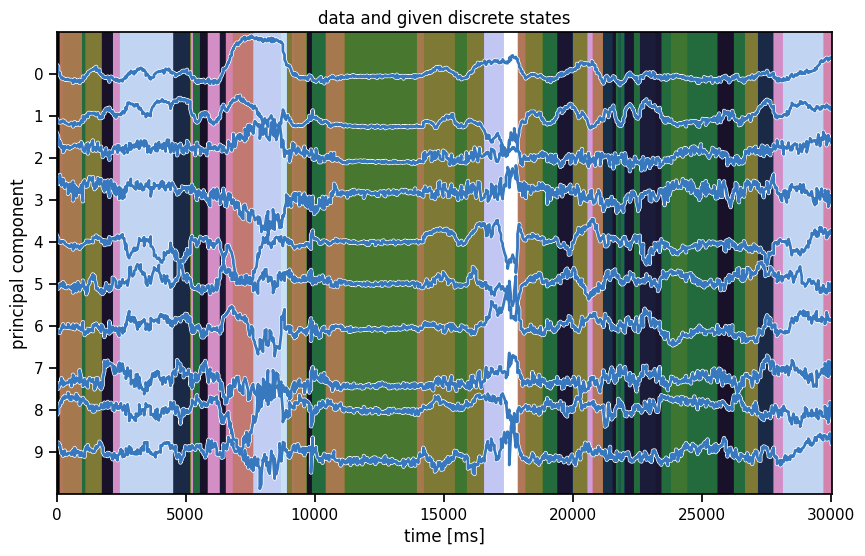

In [27]:
plot_data_and_states(train_dataset[0], train_dataset[0]["labels"],
                     title="data and given discrete states")

### Summary

You should now have a `train_dataset` and a `test_dataset` loaded in memory. Each dataset is a list of dictionaries, one for each mouse. Each dictionary contains a few keys, most important of which is the `data` key, containing the standardized principal component time series, as shown above. For the test dataset, we also included the `frames` key, which has the original 80x80 images. We'll use these to create the movies of each inferred state.

**Note:** Keeping the data in memory is costly but convenient.  You shouldn't run out of memory in this lab, but if you ever did, a better solution might be to write the preprocessed data (e.g. with the standardized PC trajectories) back to the NWB files and reload those files as necessary during fitting.

## Part 1: Implement the forward-backward algorithm

First, implement the forward-backward algorithm for computing the posterior distribution on latent states of a hidden Markov model, $q(z) = p(z \mid x, \Theta)$. Specifically, this algorithm will return a $T \times K$ matrix where each entry represents the posterior probability that $q(z_t = k)$.

### Helper functions to create random parameters

In [18]:
def sticky_transitions(num_states, stickiness=0.95):
    P = stickiness * torch.eye(num_states)
    P += (1 - stickiness) / (num_states - 1) * (1 - torch.eye(num_states))
    return P

def random_args(num_timesteps, num_states, seed=0,
                offset=0, scale=1):
    torch.manual_seed(seed)
    pi = torch.ones(num_states) / num_states
    P = sticky_transitions(num_states)
    log_likes = offset + scale * Normal(0,1).sample((num_timesteps, num_states))
    return pi, P, log_likes

### Problem 1a: Implement the forward pass

As we derived in class, the forward pass recursively computes the _normalized_ forward messages $\tilde{\alpha}_t$ and the marginal log likelihood $\log p(x \mid \Theta) = \sum_{t} \log A_t$.

**Notes**:
- This function takes in the _log_ likelihoods, $\log \ell_{tk}$, so you'll have to exponentiate in the forward pass
- You need to be careful exponentiating though. If the log likelihoods are very negative, they'll all be essentially zero when exponentiated and you'll run into a divide-by-zero error when you compute the normalized forward message. Alternatively, if they're large positive numbers, your exponent will blow up and you'll get nan's in your calculations.
- To avoid numerical issues, subtract $\max_k (\log \ell_{tk})$ prior to exponentiating. It won't affect the normalized messages, but you will have to account for it in your computation of the marginal likelihood.


In [19]:
def forward_pass(initial_dist, transition_matrix, log_likes):
    """
    Perform the (normalized) forward pass of the HMM.

    Parameters
    ----------
    initial_dist: $\pi$, the initial state distribution. Length K, sums to 1.
    transition_matrix: $P$, a KxK transition matrix. Rows sum to 1.
    log_likes: $\log \ell_{t,k}$, a TxK matrix of _log_ likelihoods.

    Returns
    -------
    alphas: TxK matrix with _normalized_ forward messages $\tilde{\alpha}_{t,k}$
    marginal_ll: Scalar marginal log likelihood $\log p(x | \Theta)$
    """
    alphas = torch.zeros_like(log_likes)
    marginal_ll = 0

    ###
    # YOUR CODE BELOW
    #
    ...
    #
    ###

    return alphas, marginal_ll

Compare outputs of your function to Dynamax outputs.

In [ ]:
def test_forward_pass(num_timesteps=100, num_states=10, offset=0):
    pi, P, log_likes = random_args(num_timesteps, num_states, offset=offset)

    # Call your code
    alphas, ll = forward_pass(pi, P, log_likes)
    assert torch.all(torch.isfinite(alphas))
    assert torch.allclose(alphas.sum(axis=1), torch.tensor(1.0))

    # Compare to Dynamax implementation.
    from dynamax.hidden_markov_model import hmm_filter
    pi_np = from_t(pi)
    P_np = from_t(P)
    log_likes_np = from_t(log_likes)

    post = hmm_filter(pi_np, P_np, log_likes_np)
    assert np.allclose(from_t(alphas), post.predicted_probs)
    assert np.allclose(from_t(ll), post.marginal_loglik)
    print("pass")

test_forward_pass()
test_forward_pass(num_timesteps=10000, num_states=50, offset=-1000)

### Problem 1b: Implement the backward pass

Recursively compute the backward messages $\beta_t$. Again, normalize to avoid underflow, and be careful when you exponentiate the log likelihoods. The same trick of subtracting the max before exponentiating will work here too.

In [21]:
def backward_pass(transition_matrix, log_likes):
    """
    Perform the (normalized) backward pass of the HMM.

    Parameters
    ----------
    transition_matrix: $P$, a KxK transition matrix. Rows sum to 1.
    log_likes: $\log \ell_{t,k}$, a TxK matrix of _log_ likelihoods.

    Returns
    -------
    betas: TxK matrix with _normalized_ backward messages $\tilde{\beta}_{t,k}$
    """
    betas = torch.zeros_like(log_likes)

    ###
    # YOUR CODE BELOW
    ...
    #
    ###

    return betas

Compare outputs of your function to Dynamax outputs.

In [ ]:
def test_backward_pass(num_timesteps=100, num_states=10, offset=0):
    pi, P, log_likes = random_args(num_timesteps, num_states, offset=offset)

    # Call your code
    betas = backward_pass(P, log_likes)
    assert torch.all(torch.isfinite(betas))
    assert torch.allclose(betas[:-1].sum(axis=1), torch.tensor(1.0))

    # Compare to Dynamax implementation.
    from dynamax.hidden_markov_model import hmm_backward_filter
    P_np = from_t(P)
    log_likes_np = from_t(log_likes)
    _, backward_pred_probs  = hmm_backward_filter(P_np, log_likes_np)
    assert np.allclose(betas, backward_pred_probs)
    print("pass")

test_backward_pass()
test_backward_pass(num_timesteps=10000, num_states=50, offset=-1000)

### Problem 1c: Combine the forward and backward passes to perform the E step

Compute the posterior marginal probabilities. We call these the `expected_states` because $q(z_t = k) = \mathbb{E}_{q(z)}[\mathbb{I}[z_t = k]]$. To copmute them, combine the forward messages, backward messages, and the likelihoods, then normalize. Again, be careful when exponentiating the likelihoods.

In [23]:
def E_step(initial_dist, transition_matrix, log_likes):
    """
    Fun the forward and backward passes and then combine to compute the
    posterior probabilities q(z_t=k).

    Parameters
    ----------
    initial_dist: $\pi$, the initial state distribution. Length K, sums to 1.
    transition_matrix: $P$, a KxK transition matrix. Rows sum to 1.
    log_likes: $\log \ell_{t,k}$, a TxK matrix of _log_ likelihoods.

    Returns
    -------
    posterior: a dictionary with the following key-value pairs:
        expected_states: a TxK matrix containing $q(z_t=k)$
        marginal_ll: the marginal log likelihood from the forward pass.
    """
    ###
    # YOUR CODE BELOW
    ...
    #
    ###

    # Package the results into a dictionary summarizing the posterior
    posterior = dict(expected_states=expected_states,
                     marginal_ll=marginal_ll)
    return posterior


Compare your outputs to Dynamax.

In [ ]:
def test_E_step(num_timesteps=100, num_states=10, offset=0):
    pi, P, log_likes = random_args(num_timesteps, num_states, offset=offset)

    # Run your code
    posterior = E_step(pi, P, log_likes)

    # Run Dynamax code
    from dynamax.hidden_markov_model import hmm_two_filter_smoother
    pi_np = from_t(pi)
    P_np = from_t(P)
    log_likes_np = from_t(log_likes)
    post = hmm_two_filter_smoother(pi_np, P_np, log_likes_np)

    assert np.allclose(posterior["expected_states"], post.smoothed_probs)
    assert np.allclose(posterior["marginal_ll"], post.marginal_loglik)
    print("pass")

test_E_step()
test_E_step(num_timesteps=10000, num_states=50, offset=-1000)

### Time it on some more realistic sizes

It should take about 4 seconds for a $T=36000$ time series with $K=50$ states. For a dataset with 24 mice, that's about 96 seconds per epoch for the E steps. (The M-steps will take about the same amount of time, so you're looking at around 1min per epoch.)

In [25]:
pi, P, log_likes = random_args(36000, 50)
%timeit E_step(pi, P, log_likes)

7.17 s ± 645 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Helper function to create a random initial posterior distribution

Finally, we'll initialize the HMM with a random posterior distribution. That way our first M step will yield reasonable parameters estimates from a random weighted combination of the data.

In [ ]:
def initialize_posteriors(dataset, num_states, seed=0):
    torch.manual_seed(seed)
    posteriors = []
    for data in dataset:
        expected_states = torch.rand(len(data["data"]), num_states)
        expected_states /= expected_states.sum(axis=1, keepdims=True)
        posteriors.append(dict(expected_states=expected_states,
                               marginal_ll=-torch.inf))
    return posteriors

## Part 2: Gaussian HMM

First we'll implement a hidden Markov model (HMM) with Gaussian observations. This is the same model we studied in class,

$$
\begin{align}
p(x, z \mid \Theta) &= \mathrm{Cat}(z_1 \mid \pi) \prod_{t=2}^{T} \mathrm{Cat}(z_t \mid P_{z_{t-1}}) \prod_{t=1}^T \mathcal{N}(x_t \mid b_{z_t}, Q_{z_t})
\end{align}
$$

with parameters $\Theta = \pi, P, \{b_k, Q_k\}_{k=1}^K$. The observed datapoints are $x_t \in \mathbb{R}^{D}$ and the latent states are $z_t \in \{1,\ldots, K\}$.

### Problem 2a: Write a Gaussian Observations object

We'll write a `GaussianObservations` class to wrap the parameters and implement key functions for EM.

Most important, `M_step` solves for the optimal parameters given the expected sufficient statistics $\overline{N}_k, \overline{\mathbf{t}}_{k,1}, \overline{\mathbf{t}}_{k,2}$, which are passed in as a tuple. The new parameters are written to the class variables `self.means` and `self.covs`

In [ ]:
class GaussianObservations(object):
    """
    Wrapper for a collection of Gaussian observation parameters.
    """
    def __init__(self, num_states, data_dim):
        """
        Initialize a collection of observation parameters for a Gaussian HMM
        with `num_states` (i.e. K) discrete states and `data_dim` (i.e. D)
        dimensional observations.
        """
        self.num_states = num_states
        self.data_dim = data_dim
        self.means = torch.zeros((num_states, data_dim))
        self.covs = torch.tile(torch.eye(data_dim), (num_states, 1, 1))

    @staticmethod
    def precompute_suff_stats(dataset):
        """
        Compute the sufficient statistics of the Gaussian distribution for each
        data dictionary in the dataset. This modifies the dataset in place.

        Parameters
        ----------
        dataset: a list of data dictionaries.

        Returns
        -------
        Nothing, but the dataset is updated in place to have a new `suff_stats`
            key, which contains a tuple of sufficient statistics.
        """
        for data in dataset:
            x = data['data']
            data['suff_stats'] = (torch.ones(len(x)),                  # 1
                                  x,                                   # x_t
                                  torch.einsum('ti,tj->tij', x, x))    # x_t x_t^T

    def log_likelihoods(self, data):
        """
        Compute the matrix of log likelihoods of data for each state.
        (I like to use torch.distributions for this, though it requires
         converting back and forth between numpy arrays and pytorch tensors.)

        Parameters
        ----------
        data: a dictionary with multiple keys, including "data", the TxD array
            of observations for this mouse.

        Returns
        -------
        log_likes: a TxK array of log likelihoods for each datapoint and
            discrete state.
        """
        x = data["data"]

        ###
        # YOUR CODE BELOW
        #
        log_likes = ...
        #
        ###
        return log_likes

    def M_step(self, stats):
        """
        Compute the Gaussian parameters give the expected sufficient statistics.

        Note: add a little bit (1e-4 * I) to the diagonal of each covariance
            matrix to ensure that the result is positive definite.

        Parameters
        ----------
        stats: a tuple of expected sufficient statistics

        Returns
        -------
        Nothing, but self.means and self.covs are updated in place.
        """
        Ns, t1s, t2s = stats

        ###
        # YOUR CODE BELOW
        ...
        #
        ###

In [ ]:
def test_gaussian(data_dim=3, seed=0):
    torch.manual_seed(0)
    data1 = Normal(0,1).sample((100, data_dim))
    data2 = Normal(0,1).sample((100, data_dim))
    data = torch.vstack([data1, data2])
    T = data.shape[0]
    num_states = 2

    obs = GaussianObservations(num_states, data_dim)
    lls = obs.log_likelihoods(dict(data=data))
    assert lls.shape == (T, num_states)
    assert torch.all(torch.isfinite(lls))
    assert torch.isclose(lls.mean(), torch.tensor(-4.3435), atol=1e-4)
    assert torch.isclose(lls.std(), torch.tensor(1.5163), atol=1e-4)

    stats = [None, None, None]
    stats[0] = 0.5 * torch.ones(2)
    stats[1] = torch.stack([data1.sum(0) / T, data2.sum(0) / T])
    stats[2] = torch.stack([data1.T @ data1 / T, data2.T @ data2 / T])

    obs.M_step(stats)
    assert torch.allclose(obs.means[0], data1.mean(axis=0))
    assert torch.allclose(obs.means[1], data2.mean(axis=0))
    assert torch.allclose(obs.covs[0], torch.cov(data1.T, correction=0) \
                        + 1e-4 * torch.eye(data_dim), atol=1e-5)
    assert torch.allclose(obs.covs[1], torch.cov(data2.T, correction=0) \
                        + 1e-4 * torch.eye(data_dim), atol=1e-5)

test_gaussian()

### Precompute the sufficient statistics

This updates the datasets in place with the sufficient statistics for a Gaussian distribution.  The statistics are placed in the `suff_stats` key.

In [ ]:
GaussianObservations.precompute_suff_stats(train_dataset)
GaussianObservations.precompute_suff_stats(test_dataset)

### Problem 2b: Write a function to compute *normalized* expected sufficient statistics

Let $M$ denote the number of mice in the dataset and let $x_t^{(m)}$ and $z_t^{(m)}$ denote their data and discrete states, respectively. Compute
- $\overline{N}_{k}$ for each of the $k$ states
- $\overline{\mathbf{t}}_{k,1} = \sum_{m=1}^M \sum_{t=1}^{T_m} q(z_{t}^{(m)} = k) \, t_1(x_t^{(m)})$ for each of the $k$ states
- $\overline{\mathbf{t}}_{k,2} = \sum_{m=1}^M \sum_{t=1}^{T_m} q(z_{t}^{(m)} = k) \, t_2(x_t^{(m)})$ for each of the $k$ states

In [ ]:
def compute_expected_suff_stats(dataset, posteriors):
    """
    Compute a tuple of normalized sufficient statistics, taking a weighted sum
    of the posterior expected states and the sufficient statistics, then
    normalizing by the length of the sequence. The statistics are combined
    across all mice (i.e. all the data dictionaries and posterior dictionaries).

    Parameters
    ----------
    dataset: a list of dictionary with multiple keys, including "data", the TxD
        array of observations for this mouse, and "suff_stats", the tuple of
        sufficient statistics.

    Returns
    -------
    stats: a tuple of normalized sufficient statistics. E.g. if the
        "suff_stats" key has four arrays, the stats tuple should have four
        entires as well. Each entry should be a K x (size of statistic) array
        with the expected sufficient statistics for each of the K discrete
        states.
    """
    assert isinstance(dataset, list)
    assert isinstance(posteriors, list)

    # Helper function to compute expected counts and sufficient statistics
    # for a single time series and corresponding posterior.
    def _compute_expected_suff_stats(data, posterior):
        ###
        # YOUR CODE BELOW
        # Hint: einsum might be useful
        q = posterior['expected_states']
        stats = ...
        #
        ###

    # Sum the expected stats over the whole dataset
    combined_T = 0
    combined_stats = None
    for data, posterior in zip(dataset, posteriors):
        this_T, these_stats = _compute_expected_suff_stats(data, posterior)
        combined_T, combined_stats = combine(
            combined_T, combined_stats, this_T, these_stats)
    return combined_stats

def test_expec_suff_stats():
    torch.manual_seed(0)
    data = train_dataset[0]
    data_dim = data['data'].shape[1]
    num_states = 10

    # make a random "posterior"
    q = torch.rand(len(data['data']), num_states)
    q /= q.sum(axis=1, keepdims=True)
    posterior = dict(expected_states=q)

    # call your function
    stats = compute_expected_suff_stats([data], [posterior])

    # Check that you have the right output shape
    assert len(stats) == 3
    assert stats[0].shape == (num_states,)
    assert stats[1].shape == (num_states, data_dim)
    assert stats[2].shape == (num_states, data_dim, data_dim)

    # Check that we got the same answer
    assert torch.allclose(stats[0][:3], torch.tensor([0.1005, 0.1001, 0.0999]), atol=1e-4)
    assert torch.allclose(stats[1][0,:3], torch.tensor([0.0324, -0.0031,  0.0422]), atol=1e-4)
    assert torch.allclose(stats[1][1,:3], torch.tensor([0.0322, -0.0024,  0.0416]), atol=1e-4)
    assert torch.allclose(stats[2][0,0,:3], torch.tensor([1.3549e-01, -1.5004e-03,  4.1387e-02]), atol=1e-4)
    assert torch.allclose(stats[2][0,1,:3], torch.tensor([-1.5004e-03,  9.7987e-02,  2.1219e-04]), atol=1e-4)

test_expec_suff_stats()

### Problem 2c: Write a function to fit an HMM with EM

In [ ]:
def fit_hmm(train_dataset,
            test_dataset,
            initial_dist,
            transition_matrix,
            observations,
            seed=0,
            num_iters=50):
    """
    Fit a Hidden Markov Model (HMM) with expectation maximization (EM).

    Note: This is only a partial fit, as this method will treat the initial
    state distribution and the transition matrix as fixed!

    Parameters
    ----------
    train_dataset: a list of dictionary with multiple keys, including "data",
        the TxD array of observations for this mouse, and "suff_stats", the
        tuple of sufficient statistics.

    test_dataset: as above but only used for tracking the test log likelihood
        during training.

    initial_dist: a length-K vector giving the initial state distribution.

    transition_matrix: a K x K matrix whose rows sum to 1.

    observations: an Observations object with `log_likelihoods` and `M_step`
        functions.

    seed: random seed for initializing the algorithm.

    num_iters: number of EM iterations.

    Returns
    -------
    train_lls: array of likelihoods of training data over EM iterations
    test_lls: array of likelihoods of testing data over EM iterations
    posteriors: final list of posterior distributions for the training data
    test_posteriors: final list of posterior distributions for the test data
    """
    # Get some constants
    num_states = observations.num_states
    num_train = sum([len(data["data"]) for data in train_dataset])
    num_test = sum([len(data["data"]) for data in test_dataset])

    # Check the initial distribution and transition matrix
    assert initial_dist.shape  == (num_states,) and \
        torch.all(initial_dist >= 0) and \
        torch.isclose(initial_dist.sum(), torch.tensor(1.0))
    assert transition_matrix.shape  == (num_states, num_states) and \
        torch.all(transition_matrix >= 0) and \
        torch.allclose(transition_matrix.sum(axis=1), torch.tensor(1.0))

    # Initialize with a random posterior
    posteriors = initialize_posteriors(train_dataset, num_states, seed=seed)
    stats = compute_expected_suff_stats(train_dataset, posteriors)

    # Track the marginal log likelihood of the train and test data
    train_lls = []
    test_lls = []

    # Main loop
    for itr in trange(num_iters):
        ###
        # YOUR CODE BELOW
        #

        # M step: update the parameters of the observations using the
        #         expected sufficient stats.
        ...

        # E step: computhe the posterior for each data dictionary in the dataset
        posteriors = ...

        # Compute the expected sufficient statistics under the new posteriors
        stats = ...

        # Store the average train likelihood
        avg_train_ll = sum([p["marginal_ll"] for p in posteriors]) / num_train
        train_lls.append(avg_train_ll)

        # Compute the posteriors for the test dataset too
        test_posteriors = ...

        # Store the average test likelihood
        avg_test_ll = sum([p["marginal_ll"] for p in test_posteriors]) / num_test
        test_lls.append(avg_test_ll)

        #
        ###

    # convert lls to arrays
    train_lls = torch.stack(train_lls)
    test_lls = torch.stack(test_lls)
    return train_lls, test_lls, posteriors, test_posteriors


### Fit it! (Just to one mouse for now...)

We'll just use the first mouse's data for now.

  0%|          | 0/50 [00:00<?, ?it/s]

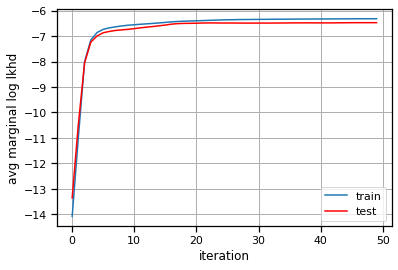

In [ ]:
# Build the HMM
num_states = 50
initial_dist = torch.ones(num_states) / num_states
transition_matrix = sticky_transitions(num_states, stickiness=0.95)
observations = GaussianObservations(num_states, data_dim)

# Fit the HMM with EM
train_lls, test_lls, train_posteriors, test_posteriors, = \
    fit_hmm(train_dataset[:1],
            test_dataset[:1],
            initial_dist,
            transition_matrix,
            observations)

plt.plot(train_lls, label="train")
plt.plot(test_lls, '-r', label="test")
plt.xlabel("iteration")
plt.ylabel("avg marginal log lkhd")
plt.grid(True)
plt.legend()

### Plot the data and the inferred latent states

We'll make the same plot as above (in the warm-up) but using our inferred states instead. Hopefully, the states seem to switch along with changes in the data.

**Note**: We're showing the state with the highest marginal probability, $z_t^\star = \mathrm{arg} \, \mathrm{max}_k \; q(z_t = k)$. This is different from the most likely state path, $z_{1:T}^\star = \mathrm{arg}\,\mathrm{max} \; q(z)$. We could compute the latter with the Viterbi algorithm, which is similar to the forward-backward algorithm you implemented above.

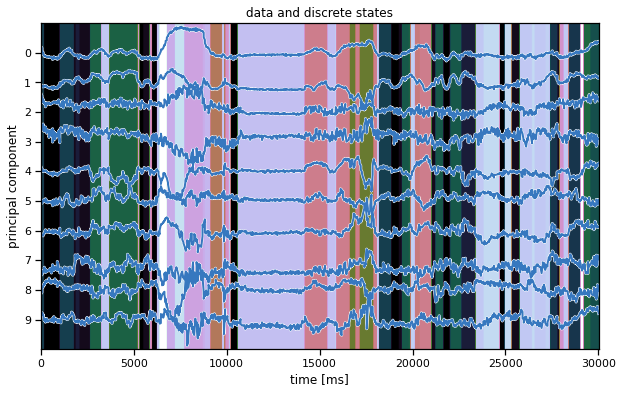

In [ ]:
ghmm_states = train_posteriors[0]["expected_states"].argmax(1)
plot_data_and_states(train_dataset[0], ghmm_states)

### Plot the state usage histogram

The state usage histogram shows how often each discrete state was used under the posterior distribution. You'll probably see a long tail of states with non-trivial usage (hundreds of frames), all the way out to state 50. That suggests the model is using all its available capacity, and we could probably crank the number of states up even further for this model.

Text(0.5, 1.0, 'histogram of inferred state usage')

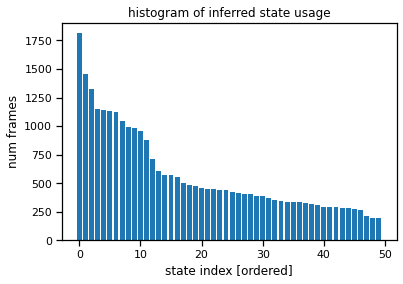

In [ ]:
# Sort states by usage
ghmm_usage = torch.bincount(ghmm_states, minlength=num_states)
ghmm_order = torch.argsort(ghmm_usage, descending=True)

plt.bar(torch.arange(num_states), ghmm_usage[ghmm_order])
plt.xlabel("state index [ordered]")
plt.ylabel("num frames")
plt.title("histogram of inferred state usage")

### Make average PC plots for each state

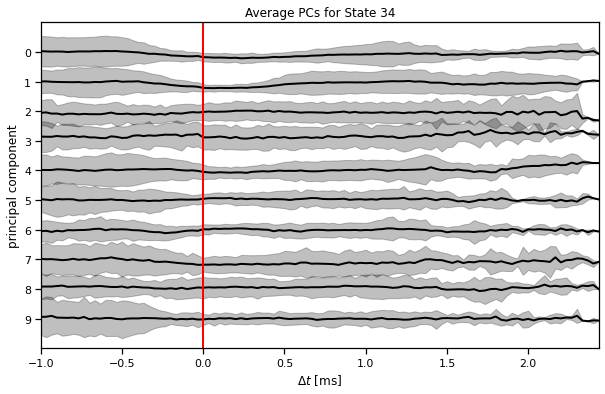

In [ ]:
plot_average_pcs(ghmm_order[3], train_dataset, train_posteriors)

### Make "crowd" movies

In [ ]:
play(make_crowd_movie(ghmm_order[0], test_dataset, test_posteriors))

Preparing animation. This may take a minute...


In [ ]:
play(make_crowd_movie(ghmm_order[1], test_dataset, test_posteriors))

Preparing animation. This may take a minute...


In [ ]:
play(make_crowd_movie(ghmm_order[2], test_dataset, test_posteriors))

Preparing animation. This may take a minute...


In [ ]:
play(make_crowd_movie(ghmm_order[3], test_dataset, test_posteriors))

Preparing animation. This may take a minute...


### Download crowd movies for each state

I've commented this out because it takes about ten minutes. Please do it once though!

In [ ]:
# # Make "crowd" movies for each state and save them to disk
# # Then you can download them and play them offline
# for i in trange(num_states):
#     try:
#         play(make_crowd_movie(order[i], test_dataset, test_posteriors),
#             filename="gaussian_hmm_crowd_{}.mp4".format(i), show=False)
#     except:
#         print("failed to create a movie for state", order[i])

# # Zip the movies up
# !zip gaussian_crowd_movies.zip gaussian_hmm_crowd_*.mp4

# # Download the file
# files.download("gaussian_crowd_movies.zip")

### Problem 2d [Short Answer]: Hyperparameter selection

The results above give some qualitative reason to believe the model is "working" reasonably. However, there are a few knobs that we had to set. What are they? How could you try to set them in a more principled manner? Is there even a "right" setting of them?

_Answer below this line_

---

## Part 3: Autoregressive HMMs

Autoregressive hidden Markov models (ARHMMs) replace the Gaussian observations with an AR model:

$$
\begin{align}
p(x, z \mid \Theta) &= \mathrm{Cat}(z_1 \mid \pi) \prod_{t=2}^{T} \mathrm{Cat}(z_t \mid P_{z_{t-1}}) \prod_{t=1}^T p(x_t \mid x_{1:t-1}, z_t)
\end{align}
$$

The model is "autoregressive" because $x_t$ depends not only on $z_t$ but on $x_{1:t-1}$ as well. The precise form of this dependence varies; here we will consider linear Gaussian dependencies on only the most recent $G$ timesteps,:

$$
\begin{align}
p(x_t \mid x_{1:t-1}, z_t) &= \mathcal{N}\left(\sum_{g=1}^G A_{z_t,g} x_{t-g} + b_{z_t,g}, Q_{z_t} \right)  
\end{align}
$$

The new parameters are $\Theta = \pi, P, \{\{A_{k,g}, b_{k,g}\}_{g=1}^G, Q_k\}_{k=1}^K$, which include weights $A_{k,g} \in \mathbb{R}^{D \times D}$ for each of the $K$ states and the $G$ lags, and a bias vector $b_k \in \mathbb{R}^D$.

Note that we can write this as a simple **linear regression**,

$$
\begin{align}
p(x_t \mid x_{1:t-1}, z_t) &= \mathcal{N}\left(W_k \phi_t , Q_{z_t} \right)  
\end{align}
$$

where $\phi_t = (x_{t-1}, \ldots, x_{t-G}, 1) \in \mathbb{R}^{GD +1}$ is a vector of covariates (aka features) that includes the past $G$ time steps along with a 1 for the bias term.

$$
\begin{align}
W_k = \begin{bmatrix} A_{k,1}  & A_{k,2} & \ldots & A_{kg} & b_k \end{bmatrix}
\in \mathbb{R}^{D \times GD + 1}
\end{align}
$$

is a block matrix of the autoregressive weights and the bias.

_Note that the covariates are fixed functions of the data so we can precompute them, if we know the number of lags $G$._

### Problem 3a [Math]: Derive the natural parameters and sufficient statistics for a linear regression

Expand the the ELBO in terms of $W_k$ and $b_k$,

$$
\begin{align}
\mathcal{L}(q, \theta) \triangleq \mathbb{E}_{q(z)}\left[ \sum_{t=1}^T \mathbb{I}[z_t=k] \cdot \log \mathcal{N}(x_t \mid W_k \phi_t, Q_k) \right] + c.
\end{align}
$$

Write it as a sum of inner products between natural parameters (i.e. functions of $W_k$ and $Q_k$) and expected sufficient statistics $\overline{N}_k$, $\bar{\mathbf{t}}_{k,1}$, $\bar{\mathbf{t}}_{k,2}$, $\bar{\mathbf{t}}_{k,3}$ (i.e. functions of $q$, $x$ and $\phi$).

**Hint**: The form should look similar to that of the Gaussian distribution we derived in class, except that now we have a three sufficient statistics and they depend on both $x$ and $\phi$.

_Answer below this line_

---

### Problem 3b [Math]: Solve for the optimal linear regression parameters given expected sufficient statistics

Solve for $W_k^\star, Q_k^\star$ that maximize the objective above in terms of the expected sufficient statistics $N_k$, $\bar{\mathbf{t}}_{k,1}$, $\bar{\mathbf{t}}_{k,2}$, $\bar{\mathbf{t}}_{k,3}$.

_Answer below this line_

---

### Problem 3c: Implement an Linear Regression Observations object

In [ ]:
class LinearRegressionObservations(object):
    """
    Wrapper for a collection of Gaussian observation parameters.
    """
    def __init__(self, num_states, data_dim, covariate_dim):
        """
        Initialize a collection of observation parameters for an HMM whose
        observation distributions are linear regressions. The HMM has
        `num_states` (i.e. K) discrete states, `data_dim` (i.e. D)
        dimensional observations, and `covariate_dim` covariates.
        In an ARHMM, the covariates will be functions of the past data.
        """
        self.num_states = num_states
        self.data_dim = data_dim
        self.covariate_dim = covariate_dim

        # Initialize the model parameters
        self.weights = torch.zeros((num_states, data_dim, covariate_dim))
        self.covs = torch.tile(torch.eye(data_dim), (num_states, 1, 1))

    @staticmethod
    def precompute_suff_stats(dataset):
        """
        Compute the sufficient statistics of the linear regression for each
        data dictionary in the dataset. This modifies the dataset in place.

        Parameters
        ----------
        dataset: a list of data dictionaries.

        Returns
        -------
        Nothing, but the dataset is updated in place to have a new `suff_stats`
            key, which contains a tuple of sufficient statistics.
        """
        ###
        # YOUR CODE BELOW
        #
        ...
        #
        ###

    def log_likelihoods(self, data):
        """
        Compute the matrix of log likelihoods of data for each state.
        (I like to use torch.distributions for this, though it requires
         converting back and forth between numpy arrays and pytorch tensors.)

        Parameters
        ----------
        data: a dictionary with multiple keys, including "data", the TxD array
            of observations for this mouse.

        Returns
        -------
        log_likes: a TxK array of log likelihoods for each datapoint and
            discrete state.
        """
        ###
        # YOUR CODE BELOW
        #
        log_likes = ...
        #
        ###
        return log_likes

    def M_step(self, stats):
        """
        Compute the linear regression parameters given the expected
        sufficient statistics.

        Note: add a little bit (1e-4 * I) to the diagonal of each covariance
            matrix to ensure that the result is positive definite.


        Parameters
        ----------
        stats: a tuple of expected sufficient statistics

        Returns
        -------
        Nothing, but self.weights and self.covs are updated in place.
        """
        Ns, t1s, t2s, t3s = stats
        ###
        # YOUR CODE BELOW
        ...
        #
        ###

### Problem 3d: Precompute the covariates for an autoregressive model

In [ ]:
def precompute_ar_covariates(dataset,
                             num_lags=2,
                             fit_intercept=True):
    for data in dataset:
        x = data["data"]
        data_dim = x.shape[1]

        ###
        # YOUR CODE BELOW
        data["covariates"] = ...
        #
        ###

### Precompute the AR features and the sufficient statistics

We'll store them in memory for convenience, even though it's redundant and memory intensive.

**Note: avoid running this cell multiple times as it will cause you to run out of memory and crash the notebook.**

In [ ]:
num_lags = 2
precompute_ar_covariates(train_dataset, num_lags=2)
precompute_ar_covariates(test_dataset, num_lags=2)
LinearRegressionObservations.precompute_suff_stats(train_dataset)
LinearRegressionObservations.precompute_suff_stats(test_dataset)

### Fit it!

This should take about 10 minutes

  0%|          | 0/50 [00:00<?, ?it/s]

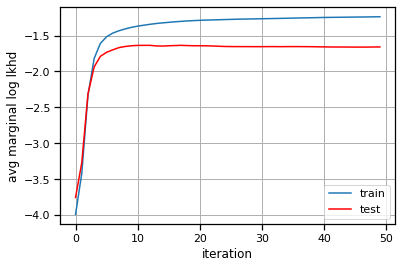

In [ ]:
# Build the HMM
num_states = 50
initial_dist = torch.ones(num_states) / num_states
transition_matrix = sticky_transitions(num_states, stickiness=0.95)
observations = LinearRegressionObservations(num_states, data_dim,
                                            num_lags * data_dim + 1)

# Fit it!
train_lls, test_lls, train_posteriors, test_posteriors, = \
    fit_hmm(train_dataset[:1],
            test_dataset[:1],
            initial_dist,
            transition_matrix,
            observations)

plt.plot(train_lls, label="train")
plt.plot(test_lls, '-r', label="test")
plt.xlabel("iteration")
plt.ylabel("avg marginal log lkhd")
plt.grid(True)
plt.legend()

### Plot the data and the inferred states


We'll make the same plot as above (in the warm-up) but using our inferred states instead. Hopefully, the states seem to switch along with changes in the data.

**Note**: We're showing the state with the highest marginal probability, $z_t^\star = \mathrm{arg} \, \mathrm{max}_k \; q(z_t = k)$. This is different from the most likely state path, $z_{1:T}^\star = \mathrm{arg}\,\mathrm{max} \; q(z)$. We could compute the latter with the Viterbi algorithm, which is similar to the forward-backward algorithm you implemented above.

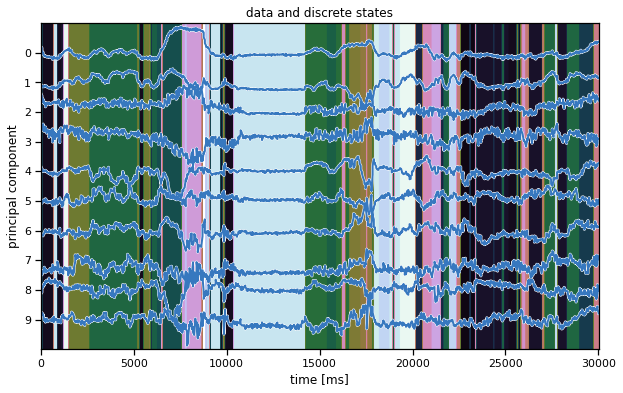

In [ ]:
arhmm_states = train_posteriors[0]["expected_states"].argmax(1)
plot_data_and_states(train_dataset[0], arhmm_states)

### Plot the state usage histogram


The state usage histogram shows how often each discrete state was used under the posterior distribution. You'll probably see a long tail of states with non-trivial usage (hundreds of frames), all the way out to state 50. That suggests the model is using all its available capacity, and we could probably crank the number of states up even further for this model.

Text(0.5, 1.0, 'histogram of inferred state usage')

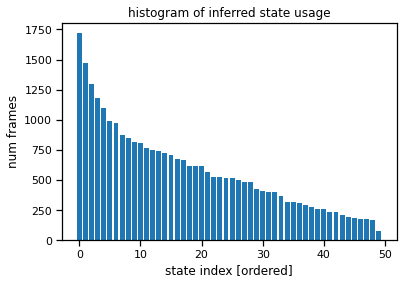

In [ ]:
# Sort states by usage
arhmm_states = train_posteriors[0]["expected_states"].argmax(1)
arhmm_usage = torch.bincount(arhmm_states, minlength=num_states)
arhmm_order = torch.argsort(arhmm_usage, descending=True)

plt.bar(torch.arange(num_states), arhmm_usage[arhmm_order])
plt.xlabel("state index [ordered]")
plt.ylabel("num frames")
plt.title("histogram of inferred state usage")

### Plot the average PC trajectory time locked to state entry

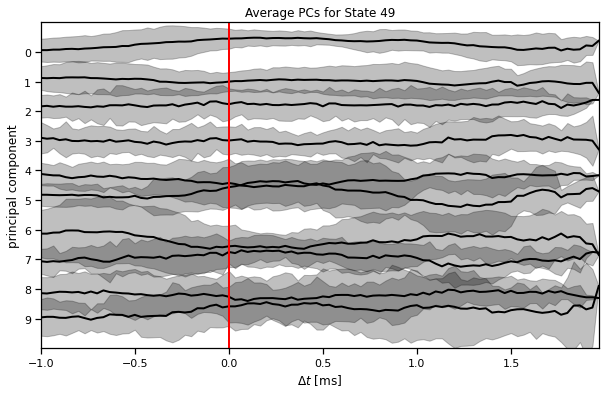

In [ ]:
plot_average_pcs(arhmm_order[34], train_dataset[:1], train_posteriors[:1])

### Plot some "crowd" movies

In [ ]:
play(make_crowd_movie(arhmm_order[0], test_dataset, test_posteriors))

Preparing animation. This may take a minute...


In [ ]:
play(make_crowd_movie(arhmm_order[1], test_dataset, test_posteriors))

Preparing animation. This may take a minute...


In [ ]:
play(make_crowd_movie(arhmm_order[2], test_dataset, test_posteriors))

Preparing animation. This may take a minute...


In [ ]:
play(make_crowd_movie(arhmm_order[3], test_dataset, test_posteriors))

Preparing animation. This may take a minute...


In [ ]:
play(make_crowd_movie(arhmm_order[4], test_dataset, test_posteriors))

Preparing animation. This may take a minute...


In [ ]:
play(make_crowd_movie(arhmm_order[20], test_dataset, test_posteriors))

Preparing animation. This may take a minute...


### Download crowd movies for each state

I've commented this out because it takes about ten minutes. Please do it once though!

In [ ]:
# # Make "crowd" movies for each state and save them to disk
# # Then you can download them and play them offline
# for i in trange(num_states):
#     play(make_crowd_movie(arhmm_order[i], test_dataset, test_posteriors),
#          filename="arhmm_crowd_{}.mp4".format(i), show=False)

# # Zip the movies up
# !zip arhmm_crowd_movies.zip arhmm_crowd_*.mp4

# from google.colab import files
# files.download("arhmm_crowd_movies.zip")

## Bonus Problem 4: Fitting ARHMMs with Stochastic EM

The EM algorithm above sweeps through the entire dataset during each E-step. In this part, you'll implement a stochastic EM algorithm that performs an E-step on one minibatch of data at a time and keeps a rolling average of the expected sufficient statistics.

### Bonus Problem 4a: Adapt your EM code to run stochastic EM instead

In [ ]:
def fit_hmm_stoch_em(train_dataset,
                     test_dataset,
                     initial_dist,
                     transition_matrix,
                     observations,
                     seed=0,
                     num_epochs=5,
                     forgetting_rate=0.5):
    """
    Fit a Hidden Markov Model (HMM) with expectation maximization (EM).

    Note: This is only a partial fit, as this method will treat the initial
    state distribution and the transition matrix as fixed!

    Parameters
    ----------
    train_dataset: a list of dictionary with multiple keys, including "data",
        the TxD array of observations for this mouse, and "suff_stats", the
        tuple of sufficient statistics.

    test_dataset: as above but only used for tracking the test log likelihood
        during training.

    initial_dist: a length-K vector giving the initial state distribution.

    transition_matrix: a K x K matrix whose rows sum to 1.

    observations: an Observations object with `log_likelihoods` and `M_step`
        functions.

    seed: random seed for initializing the algorithm.

    num_iters: number of EM iterations.

    forgetting_rate: number > 0 that controls how quickly the step size decays.

    Returns
    -------
    train_lls: array of likelihoods of training data over EM iterations
    test_lls: array of likelihoods of testing data over EM iterations
    posteriors: final list of posterior distributions for the training data
    test_posteriors: final list of posterior distributions for the test data
    """

    # Get some constants
    num_batches = len(train_dataset)
    num_states = observations.num_states
    num_train = sum([len(data["data"]) for data in train_dataset])
    num_test = sum([len(data["data"]) for data in test_dataset])

    # Initialize the step size schedule
    schedule = torch.arange(1, 1 + num_batches * num_epochs)**(-0.5)

    # Initialize progress bars
    outer_pbar = trange(num_epochs)
    inner_pbar = trange(num_batches)
    outer_pbar.set_description("Epoch")
    inner_pbar.set_description("Batch")

    # Initialize with a random posterior on the first batch
    posteriors = initialize_posteriors(train_dataset[:1], num_states, seed=seed)
    stats = compute_expected_suff_stats(train_dataset[:1], posteriors[:1])

    # Main loop
    torch.manual_seed(seed)
    train_lls = []
    test_lls = []
    for epoch in range(num_epochs):
        perm = torch.arange(num_batches) # could randomize

        inner_pbar.reset()
        for itr in range(num_batches):
            minibatch = [train_dataset[perm[itr]]]
            this_num_train = len(minibatch[0]["data"])

            # M step: using current stats
            ...

            # E step: on this minibatch
            posteriors = ...

            # Compute sufficient statistics for this batch
            these_stats = ...

            # Take a convex combination of the statistics using current step sz
            stepsize = schedule[epoch * num_batches + itr]
            stats = ...

            # Store the normalized log likelihood for this minibatch
            avg_mll = sum([p["marginal_ll"] for p in posteriors]) / this_num_train
            train_lls.append(avg_mll)
            inner_pbar.set_description("Batch LL: {:.3f}".format(avg_mll))
            inner_pbar.update()


        # Evaluate the likelihood and posteriors on the test dataset
        test_posteriors = ...

        avg_test_mll = sum([p["marginal_ll"] for p in test_posteriors]) / num_test
        test_lls.append(avg_test_mll)
        outer_pbar.set_description("Test LL: {:.3f}".format(avg_test_mll))
        outer_pbar.update()

    # Finally, compute the posteriors for each training dataset
    print("Computing posteriors for the whole training dataset")
    posteriors = ...

    # convert lls to arrays
    train_lls = torch.stack(train_lls)
    test_lls = torch.stack(test_lls)

    return train_lls, test_lls, posteriors, test_posteriors

In [ ]:
# Build the HMM
num_states = 50
initial_dist = torch.ones(num_states) / num_states
transition_matrix = sticky_transitions(num_states, stickiness=0.95)
observations = LinearRegressionObservations(num_states, data_dim,
                                            num_lags * data_dim + 1)

# Fit it with stochastic EM
train_lls, test_lls, train_posteriors, test_posteriors, = \
    fit_hmm_stoch_em(train_dataset,
                     test_dataset,
                     initial_dist,
                     transition_matrix,
                     observations)

# Interpolate the test lls at each minibatch
test_lls = torch.concatenate([[torch.nan], test_lls])
test_lls = torch.concatenate([
    torch.repeat(test_lls[:-1], len(train_dataset)), [test_lls[-1]]])

plt.plot(train_lls, label="train")
plt.plot(test_lls, '-r', label="test")
plt.xlabel("iteration")
plt.ylabel("avg marginal log lkhd")
plt.grid(True)
plt.legend(loc="lower right")

### Plot the data and the inferred states


We'll make the same plot as above (in the warm-up) but using our inferred states instead. Hopefully, the states seem to switch along with changes in the data.

**Note**: We're showing the state with the highest marginal probability, $z_t^\star = \mathrm{arg} \, \mathrm{max}_k \; q(z_t = k)$. This is different from the most likely state path, $z_{1:T}^\star = \mathrm{arg}\,\mathrm{max} \; q(z)$. We could compute the latter with the Viterbi algorithm, which is similar to the forward-backward algorithm you implemented above.

In [ ]:
plot_data_and_states(train_dataset[0],
                     train_posteriors[0]["expected_states"].argmax(1))

### Plot the state usage histogram

In [ ]:
## Sort states by usage
arhmm_sem_usage = 0
for posterior in train_posteriors:
    states = np.argmax(posterior["expected_states"], axis=1)
    arhmm_sem_usage += np.bincount(states, minlength=num_states)
arhmm_sem_order = np.argsort(arhmm_sem_usage)[::-1]

plt.bar(np.arange(num_states), arhmm_sem_usage[arhmm_sem_order])
plt.xlabel("state index [ordered]")
plt.ylabel("num frames")
plt.title("histogram of inferred state usage")

### Plot PC trajectories upon state entry


In [ ]:
plot_average_pcs(arhmm_sem_order[44], train_dataset, train_posteriors)

### Make "crowd" movies


In [ ]:
play(make_crowd_movie(arhmm_sem_order[49], test_dataset, test_posteriors))

### Download crowd movies for each state

I've commented this out because it takes about ten minutes. Please do it once though!

In [ ]:
# # Make "crowd" movies for each state and save them to disk
# # Then you can download them and play them offline
# for i in trange(num_states):
#     play(make_crowd_movie(arhmm_sem_order[i], test_dataset, test_posteriors),
#          filename="arhmm_sem_crowd_{}.mp4".format(i), show=False)

# # Zip the movies up
# !zip arhmm_sem_crowd_movies.zip arhmm_sem_crowd_*.mp4

# from google.colab import files
# files.download("arhmm_sem_crowd_movies.zip")